# An analysis of noise levels in encoder data
Doug Ollerenshaw  
dougo@alleninstitute.org  
6/24/2020  

During analysis of ophys data, a number of us have made note of occasional large and obviously spurious transients in the running data. Late last week I set about trying to better understand the source of those transients. In the process, I discovered surprisingly high noise levels in the raw-voltages being acquired from the rotary encoders in our behavioral setups. The algorithm for processing running data includes a step that applies a 5-element median filter to the raw voltages prior to calculating the running velocity - a processing step that had been largely obscuring the noise issues (though the above-mentioned transients were a related phenomenon).

This notebook is an attempt at succinctly describing the signals extracted from the encoder, the method I used to characterize the noise levels, and the variability of those noise levels across rigs. Some recommendations for the future are described at the bottom in the conclusions section.

In [1]:
import visual_behavior.data_access.loading as loading
from visual_behavior.translator.foraging2 import data_to_change_detection_core
from visual_behavior.translator.foraging import data_to_change_detection_core as data_to_change_detection_core_legacy
import visual_behavior.database as db
from visual_behavior import analyze

import pandas as pd
import seaborn as sns

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_api/behavior_ophys_nwb_api.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%matplotlib notebook

In [3]:
cache = loading.get_visual_behavior_cache()
behavior_session_table = cache.get_behavior_session_table()

# Some local convenience function definitions:

### a simple method for locating a session's PKL file by behavior_session_id, then getting encoder data

In [4]:
def load_running_df(bsid=None,pkl_path=None,camstim_type='foraging2'):
    '''
    loads running data from pkl file using VBA
    input is either the behavior session ID (bsid) or the pkl path (not both!)
    '''
    if bsid:
        pkl_path = db.get_pkl_path(int(bsid))
    
    data = pd.read_pickle(pkl_path)
    if camstim_type == 'foraging2':
        core_data = data_to_change_detection_core(data)
    else:
        core_data = data_to_change_detection_core_legacy(data)
    return core_data['running']

### a function to make a summary plot of the raw data streams

In [24]:
def make_summary_plot(running_df, x_lims=None):
    if x_lims:
        running_df = running_df.query('time >= {} and time <= {}'.format(x_lims[0], x_lims[1]))
    fig,ax=plt.subplots(3,1,figsize=(10,8),sharex=True)
    ax[0].plot(
        running_df['time'],
        running_df['v_in']
    )
    ax[0].plot(
        running_df['time'],
        running_df['v_sig'],
        marker='.',
    )
    ax[0].legend(['v_in','v_sig'])
    ax[0].set_ylabel('V')
    ax[0].set_title('raw voltages from encoder (v_in should be constant, v_sig varies with running)')

    ax[1].plot(
        running_df['time'],
        running_df['dx']
    )
    ax[1].set_ylabel('deg')
    ax[1].set_title('derived angular change since the last timestep calculated by camstim (called `dx` in the PKL file)')

    ax[2].plot(
        running_df['time'],
        running_df['speed']
    )
    ax[2].set_xlabel('time (s)')
    ax[2].set_ylabel('speed (cm/s)')
    ax[2].set_title('running speed calculated using standard VBA algorithm (SDK algorithm is similar)')
    fig.tight_layout()
    return fig,ax

### a function to add some derived columns to the running dataframe

In [6]:
def add_columns_to_running_df(running_df):
    running_df_local = running_df.copy()
    running_df_local['dt'] = running_df_local['time'].diff().shift()
    running_df_local['v_sig_last'] = running_df_local['v_sig'].shift()
    running_df_local['v_sig_diff'] = running_df_local['v_sig'] - running_df_local['v_sig_last']
    running_df_local['dvdt'] = running_df_local['v_sig_diff']/running_df_local['dt']
    
    # cut out the big diffs caused by the threshold crossings
    cutoff_threshold = 50 # maximum dv/dt to display
    running_df_local.loc[running_df_local[running_df_local['dvdt'].abs() > cutoff_threshold].index,'dvdt'] = np.nan
    
    return running_df_local

### a function to plot the raw voltage noise along with the rolling mean

In [43]:
def make_noise_characterization_plot(running_df, x_lims=None):
    
    running_df_local = add_columns_to_running_df(running_df)
    
    if x_lims:
        running_df_local = running_df_local.query('time >= {} and time <= {}'.format(x_lims[0], x_lims[1]))
    fig,ax=plt.subplots(2,1,figsize=(10,6),sharex=True)
    
    ax[0].plot(
        running_df_local['time'],
        running_df_local['v_in']
    )
    ax[0].plot(
        running_df_local['time'],
        running_df_local['v_sig'],
        marker='.',
    )
    ax[0].legend(['v_in','v_sig'])
    ax[0].set_ylabel('V')
    ax[0].set_title('raw voltages from encoder (v_in should be constant, v_sig varies with running)')
    
    ax[1].plot(
        running_df_local['time'],
        running_df_local['dvdt']
    )
    ax[1].plot(
        running_df_local['time'],
        running_df_local['dvdt'].rolling(window=10,center=True,min_periods=0).mean()
    )
    ax[1].set_xlabel('time (s)')
    ax[1].set_ylabel('dv/dt (V/s)')
    ax[1].legend(['raw','10 element moving average'])
    ax[1].set_title('derivative of voltage signal with moving average overlaid')
    
    return fig,ax

### a function to make a histogram of the voltage noise. I'm using the standard deviation of this histogram as a metric for how noisy a given session is

In [44]:
def make_noise_histogram(running_df):
    
    running_df_local = add_columns_to_running_df(running_df)
    
    fig,ax=plt.subplots(figsize=(5,5))
    noise_dist = running_df_local['dvdt'] - running_df_local['dvdt'].rolling(window=10,center=True,min_periods=0).mean()
    ax.hist(
        noise_dist,
        bins = np.arange(-5,5,0.05)
    );
    ax.set_xlabel('dv/dt - 10 point rolling mean')
    ax.set_ylabel('counts')
    ax.set_title('voltage derivatives minus rolling mean\nstd = {:0.3f}'.format(noise_dist.std()))
    
    return fig,ax

# Now look at a couple example sessions to get a sense of what the raw data looks like

### first is a session acquired on the mesoscope on 9/14/19
### This is an example of a relatively low-noise session

In [68]:
bsid = 938991494
running_df = load_running_df(bsid)
behavior_session_table.loc[bsid]

ophys_session_id                                          9.38899e+08
behavior_training_id                                              NaN
equipment_name                                                 MESO.1
date_of_acquisition                           2019-09-04 15:32:34.106
donor_id                                                    840378930
full_genotype           Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
reporter_line                            [Ai148(TIT2L-GC6f-ICL-tTA2)]
driver_line                                            [Vip-IRES-Cre]
sex                                                                 M
age_in_days                                                       208
foraging_id                      6bdfcbfb-32b1-46ed-bb76-915a28c63e55
session_type                                 OPHYS_2_images_A_passive
Name: 938991494, dtype: object

### this plot shows the raw values extracted from the encoder, plus the derived linear speed of the mouse using the standard VBA algorithm (which was used almost verbatim in the SDK)

The plots show:
* The raw voltage values. The time varying signal (in orange) indicates the angular position of the encoder in its range between 0 and V_in (shown in blue).
* The derived angular change since the last timestep, in units of degrees. Camstim calculates this in realtime and saves it as the variable `dx`. But it can also be reconstructed from the raw voltage values. Note that this column is in degrees (so calling it 'dx' is a misnomer, it should really be called 'd_theta'). To convert it to an angular rate, it is divided by the time between datapoints (dt).
* The derived linear speed. This is calculated by first median-filtering `dx`, converting it to rate (deg/s), then converting it to a linear speed using the radius of the running wheel. (Note the transient at ~1534 seconds, which is an artifact occasionally introduced by the method used to correct for the 5V-to-0V crossings. It is these artifacts that I set out to correct, and which led me to discover the larger noise issue discussed here).

<IPython.core.display.Javascript object>


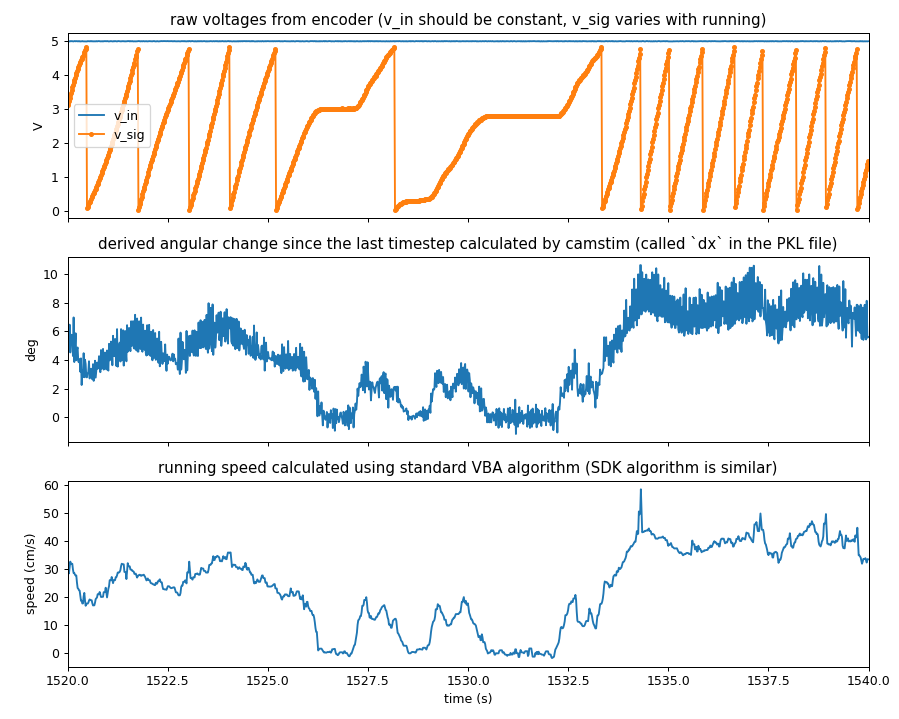

(1520.0, 1540.0)

In [69]:
fig,ax = make_summary_plot(running_df,x_lims=(1520,1540))
ax[0].set_xlim(1520,1540)

### this plot explains the method I used to characterize the noise
In the plot above, there is clearly noise in the `dx` measurement that is used to calculate the running speed. However, since `dx` is derived from the raw voltages, I reasoned that it would be most sensible to characterize the noise in th raw voltages themselves.

And since the overall variance of the voltage signal will be affected by the animal's running speed, I also reasoned that the variance around a local mean would be a more meaningful measure of the noise. I therefore calculated the change in voltage at each timestep, divided by the change in time (`dv\dt`, shown in blue in the lower plot), then convolved it with a 10 sample boxcar filter to get a rolling local average (shown in orange below).

<IPython.core.display.Javascript object>


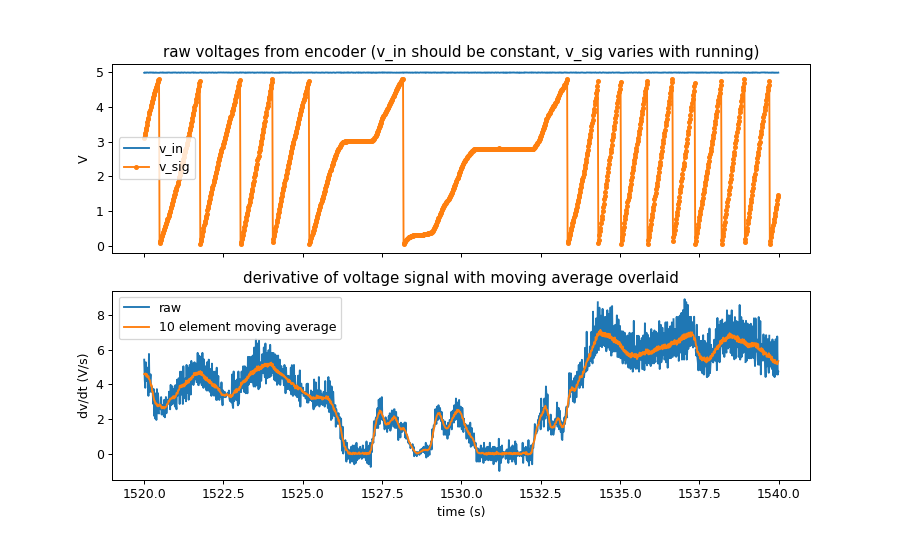

In [47]:
fig,ax=make_noise_characterization_plot(running_df, x_lims=(1520,1540))

### This plot shows the histogram of noise values
At each point, I simply subtracted the raw voltage derivative (`dv\dt`) from the rolling average, the plotted the histogram. 

This was repeated for every session, then I compared the standard deviation of this distribution for each session (see further below) as a method for comparing noise across sessions.

This distribution obviously isn't normal. In this case, it's actually bimodal. I believe the reason for this is that the voltage derivative varies over a wider range when the animal is running, combined with the fact that the noise appears to be asymmetric.

<IPython.core.display.Javascript object>


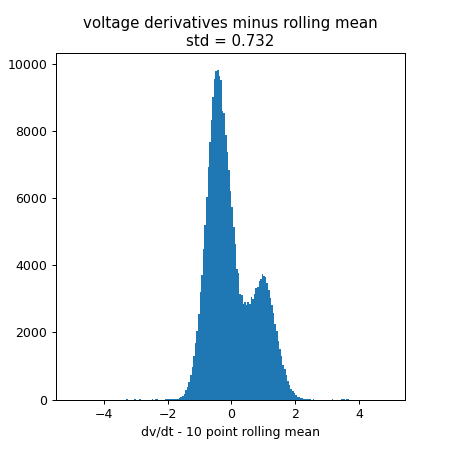

In [48]:
fig,ax = make_noise_histogram(running_df)

### here's another example session, this one from 2P5 on 10/31/19. 

### This is an example of a relativly high-noise session

In [56]:
bsid = 974807143
running_df = load_running_df(bsid)
behavior_session_table.loc[bsid]

ophys_session_id                                               9.7466e+08
behavior_training_id                                                  NaN
equipment_name                                                    CAM2P.5
date_of_acquisition                               2019-10-31 11:26:52.132
donor_id                                                        925234041
full_genotype           Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...
reporter_line                                        [Ai93(TITL-GCaMP6f)]
driver_line                               [Camk2a-tTA, Slc17a7-IRES2-Cre]
sex                                                                     M
age_in_days                                                           119
foraging_id                          256de2c5-052c-44ca-8c32-8ef5c43680ef
session_type                                             OPHYS_3_images_A
Name: 974807143, dtype: object

### here are the raw values. Notice the obviously higher noise in the `dx` signal

<IPython.core.display.Javascript object>


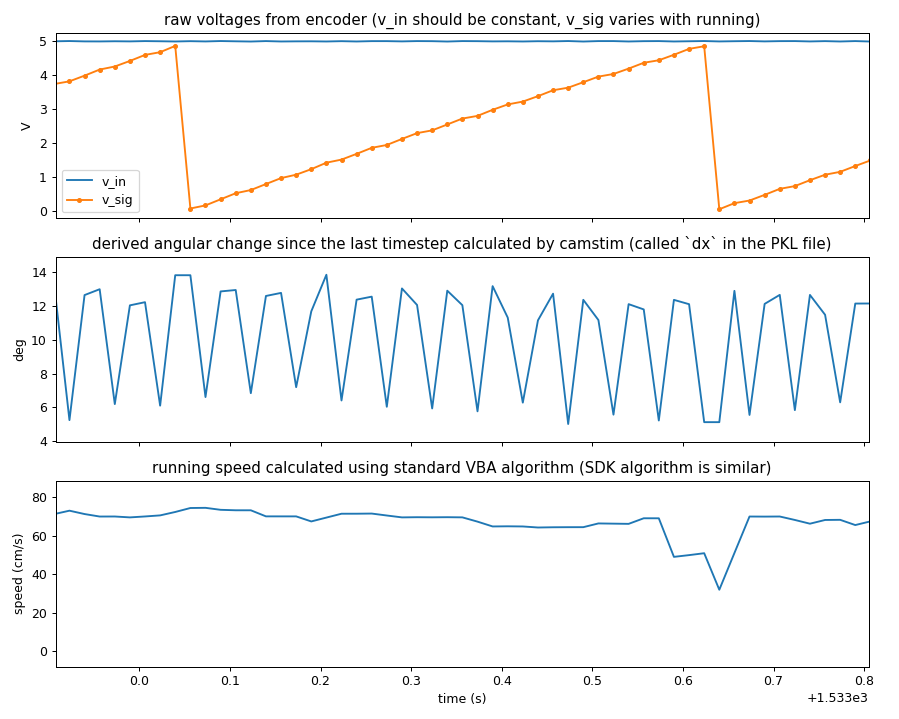

(1520.0, 1540.0)

In [57]:
fig,ax = make_summary_plot(running_df,x_lims=(1520,1540))
ax[0].set_xlim(1520,1540)

### Here is the plot showing the voltage derivative, plus its rolling mean. The high noise levels are also visible here

<IPython.core.display.Javascript object>


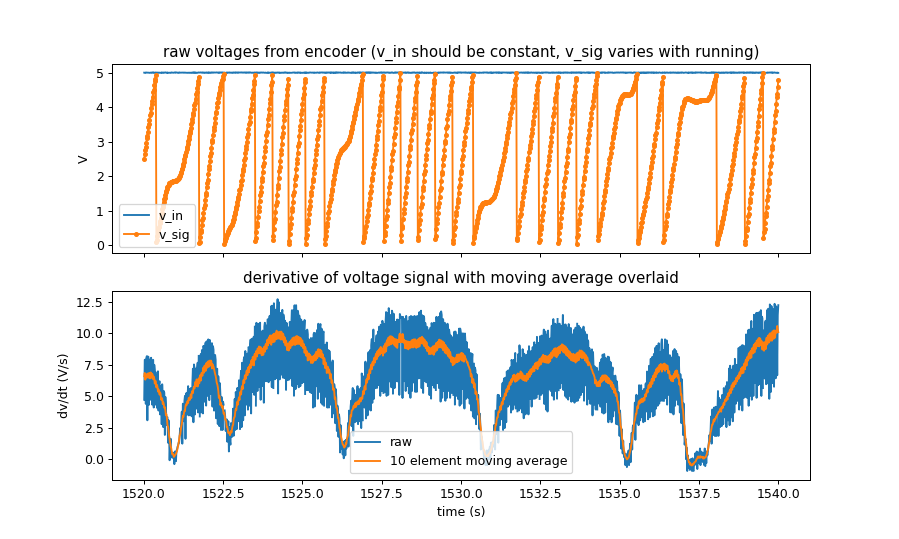

In [58]:
fig,ax=make_noise_characterization_plot(running_df, x_lims=(1520,1540))

### And the distribution of voltage derivatives minus the mean
This distribution is obviously wider than above, and the standard deviation reflects that.

It's also obviously tri-modal. Again, I think that results from a combination of asymmetric noise and variance of the noise scaling with running speed. Standard deviation therefore isn't a perfect measure, given the lack of normality, but it still captures the overall phenomenon.

<IPython.core.display.Javascript object>


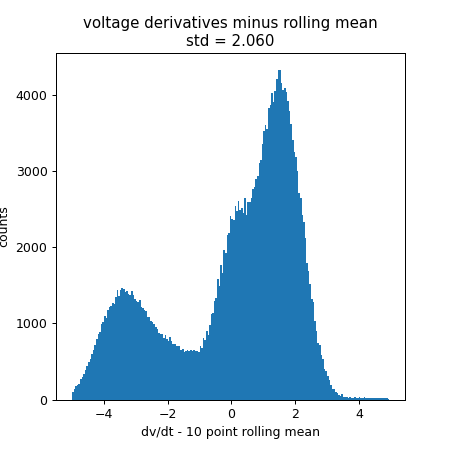

In [59]:
fig,ax = make_noise_histogram(running_df)

### and for reference, here is an older pre-production session with lower noise levels, which points to the very high noise being a relatively new phenomenon

In [60]:
pkl_path = "/allen/programs/braintv/workgroups/neuralcoding/Behavior/Data/M318631/output/170728092742-task=DoC_NaturalImages_CAMMatched_n=8_stage=natural_images_drop_reward_mouse=M318631.pkl"
running_df = load_running_df(pkl_path=pkl_path,camstim_type='legacy')

<IPython.core.display.Javascript object>


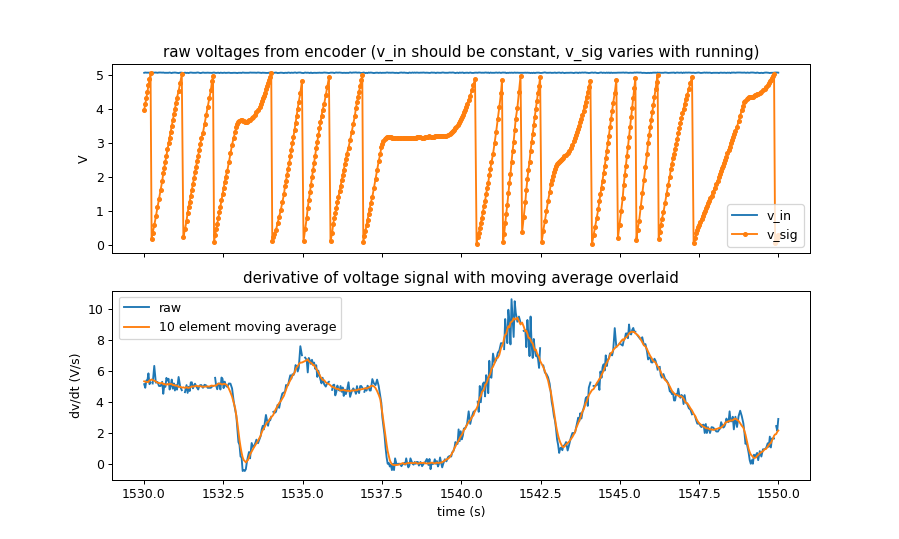

In [61]:
fig,ax=make_noise_characterization_plot(running_df, x_lims=(1530,1550))

<IPython.core.display.Javascript object>


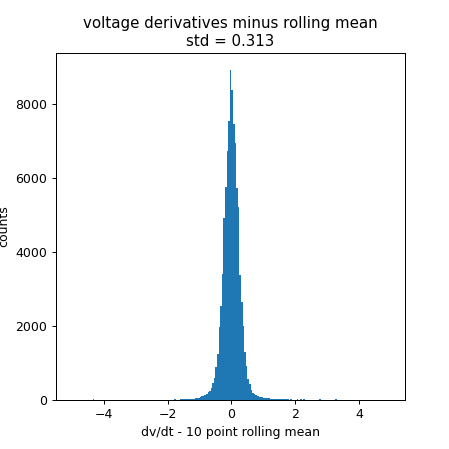

In [62]:
fig,ax = make_noise_histogram(running_df)

## here is the summary across all production sessions (not separated by individual rig on the behavior clusters since the SDK does not provide that information as of now. See https://github.com/AllenInstitute/AllenSDK/issues/1633)

This summary includes almost 10,000 behavior sessions spanning both all of the rigs (behavior-only, neuropixels, ophys). Since each session requires 30-60 seconds to open and process, I performed this in parallel on the compute cluster, then cached all results in a Mongo database.

### Here is code to retrieve the extracted noise summaries from mongo

In [63]:
conn = db.Database('visual_behavior_data')
collection = conn['behavior_analysis']['running_data_summary']
encoder_summary = pd.DataFrame(list(collection.find({})))
conn.close()
print('there are {} unique sessions analyzed'.format(len(encoder_summary)))

there are 9982 unique sessions analyzed


### This is the distribution of all standard deviations of the noise distributions. Lower = better.

<IPython.core.display.Javascript object>


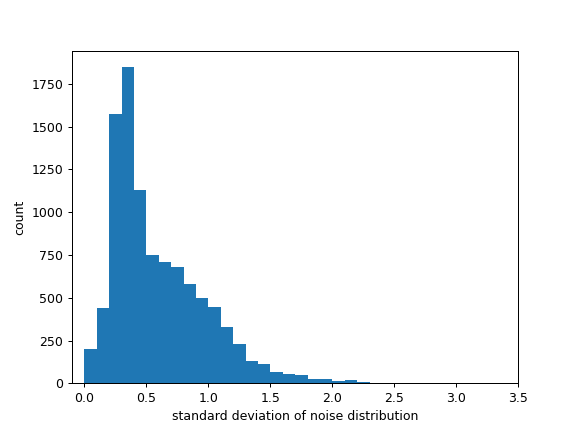

(-0.1, 3.5)

In [64]:
fig,ax=plt.subplots()
ax.hist(encoder_summary['std'],bins=np.arange(0,np.max(encoder_summary['std']),0.1));
ax.set_xlabel('standard deviation of noise distribution')
ax.set_ylabel('count')
ax.set_xlim(-0.1,3.5)

### Median standard devitaion by `equipment_name`
Note that it would be possible to separate this by individual behavior rig if we wanted, but it would require re-opening every PKL file to get that information since it is not currently being extracted by the SDK.

In [65]:
encoder_summary.groupby('equipment_name')['std'].median().sort_values()

equipment_name
BEH.D      0.278380
WF.1       0.288426
BEH.G      0.350844
BEH.E      0.397137
BEH.F      0.427715
BEH.B      0.468946
NP.1       0.507175
MESO.1     0.540074
NP.0       0.640234
CAM2P.3    0.721267
NP.3       0.725210
CAM2P.5    0.911803
CAM2P.4    1.185307
Name: std, dtype: float64

### a box plot of noise distribution standard deviation by `equipment_name`

<IPython.core.display.Javascript object>


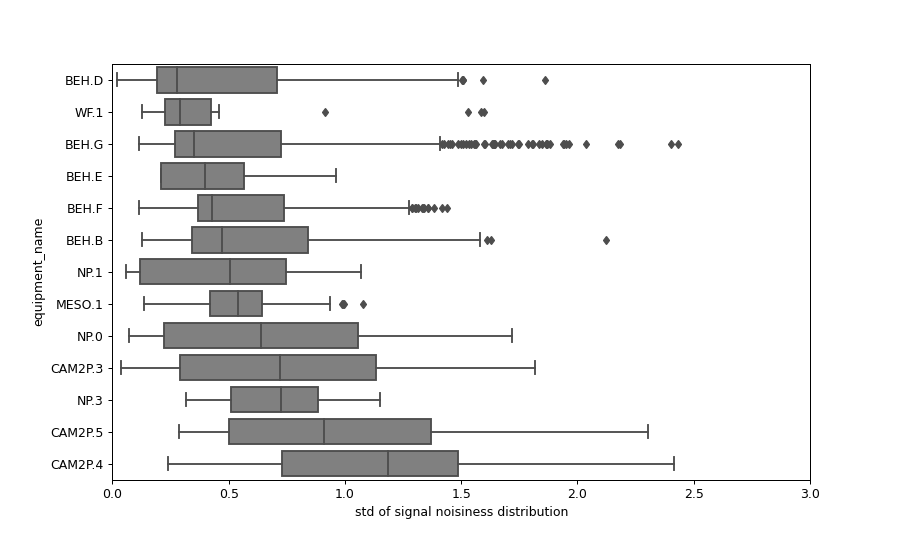

(0.0, 3.0)

In [66]:
order = encoder_summary.groupby('equipment_name')['std'].median().sort_values().index
fig,ax=plt.subplots(figsize=(10,6))
sns.boxplot(
    data = encoder_summary,
    x='std',
    y='equipment_name',
    order = order,
    color='gray',
    ax=ax
)
ax.set_xlabel('std of signal noisiness distribution')
ax.set_xlim(0,3)

# Conclusion
Clearly there is variability in encoder noise across rigs, and unfortunately the physiology rigs seem to have the noisiest data. It's not obvious at this point where the noise is coming from. Four obvious possibilities are:
* The encoders themselves
* The connector between the behavior stage and the wiring harness (this seems likely given that the widefield rig, which uses a standard 15-pin connector instead of the "hot-shoe" connector, has some of the lowest noise values)
* Some other point in the wiring harness
* The data acquisition boards (though this seems least likely, especially since the physiology rigs have higher quality DAQs than the behavior boxes, yet still have more noise issues).

Going forward, we should accelerate plans to replace the analog rotary encoders with digital versions, and we should also put in place a check on the noise levels in the measurement during the QC process. Even the lower noise example above is still quite noisy, so QC thresholds should be determined based on noise characteristics of the digital encoders, not on past data.

For existing data, we will need to revisit our filtering and processing algorithms to deal with the high noise levels in our data. Since running is a smoothly varying process, it should be possible to extract the general trend in spite of the high-amplitude/high-frequency noise. However, we will need to take care that filters do not introduce artifacts (e.g., shifts in time) that might ultimately skew the interpretation of the data. In addition, we will need to be transparent with data consumers about the processing steps used to eliminate the noise.